In [17]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pandas import DataFrame
from pandas_datareader import data
from bokeh.plotting import figure, output_file, show
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import ColumnDataSource
from bokeh.models import LinearAxis, Range1d
from bokeh.layouts import gridplot
import seaborn as sns
import matplotlib.dates as mdates

In [6]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [8]:
opsd_daily
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.day_name()
# Display a random sampling of 5 rows
opsd_daily.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


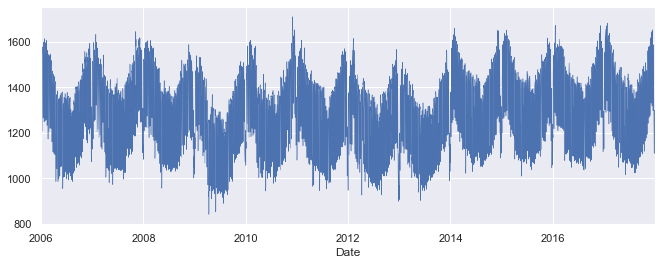

In [13]:
sns.set(rc={'figure.figsize':(11, 4)})
opsd_daily['Consumption'].plot(linewidth=0.5);

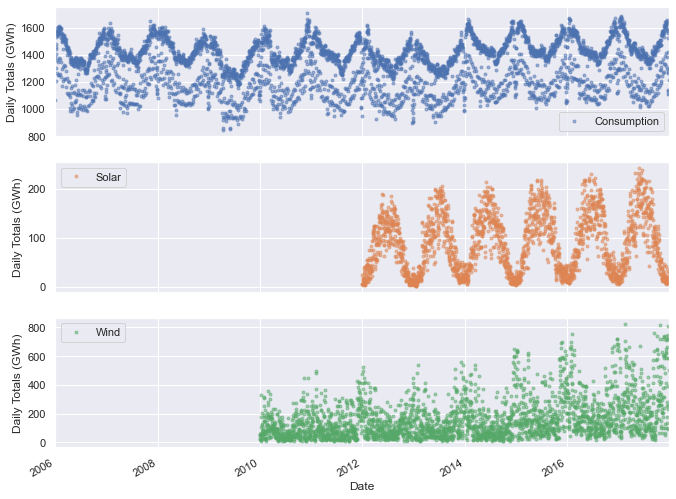

In [14]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

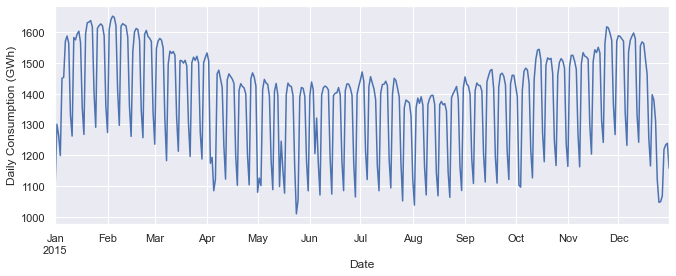

In [15]:
#opsd_daily['Consumption'].plot(kind="hist")
ax = opsd_daily.loc['2015', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

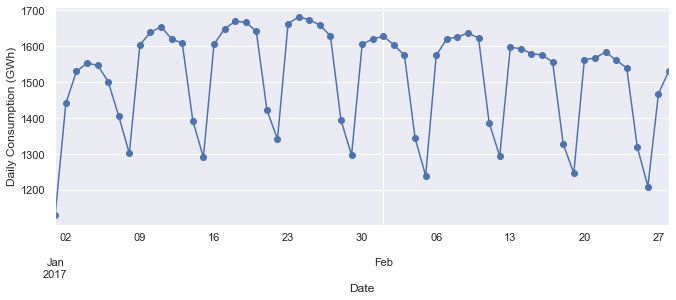

In [16]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');

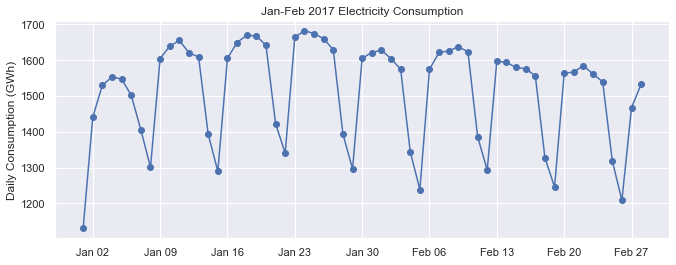

In [18]:
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

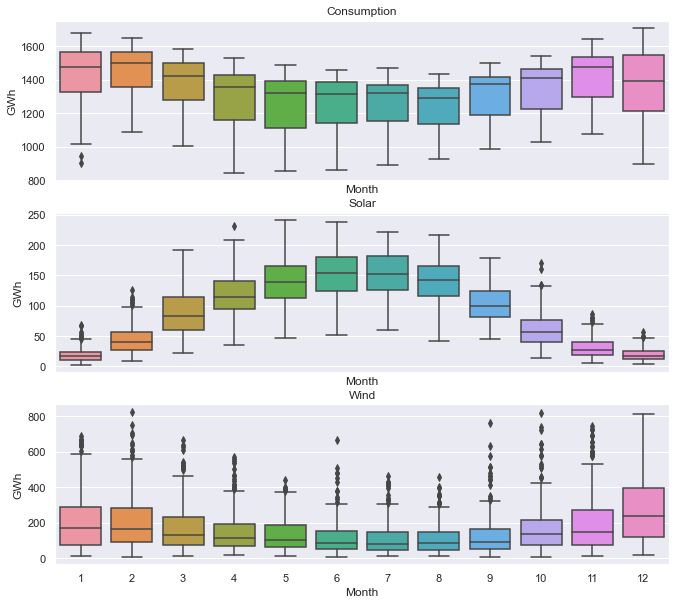

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
    sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

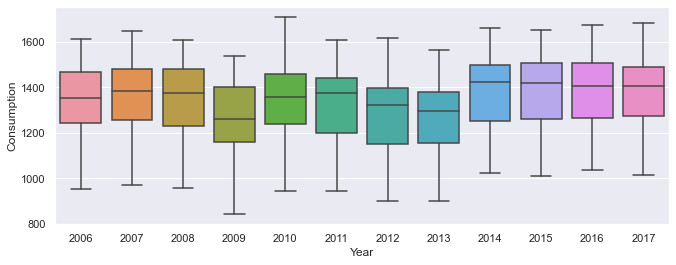

In [20]:
sns.boxplot(data=opsd_daily, x='Year', y='Consumption');

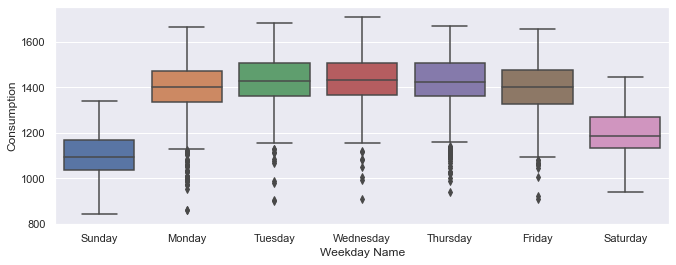

In [21]:
sns.boxplot(data=opsd_daily, x='Weekday Name', y='Consumption');

In [22]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [27]:
 # Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
# Resample to weekly frequency, aggregating with mean
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


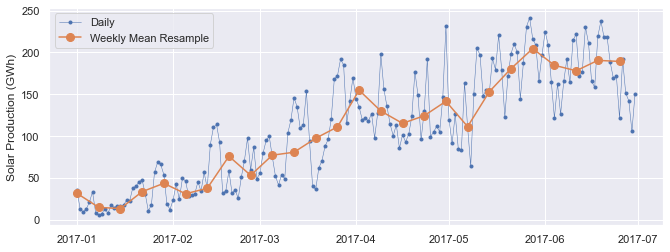

In [28]:
start, end = '2017-01', '2017-06'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

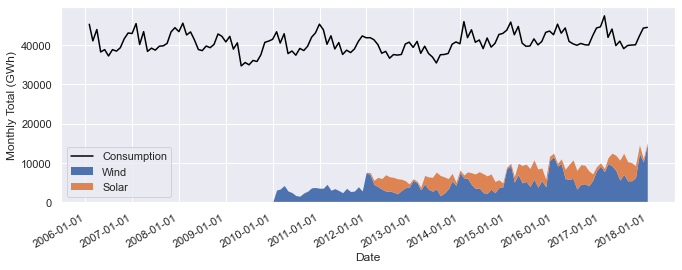

In [31]:
opsd_monthly = opsd_daily[data_columns].resample('M').sum(min_count=28)
opsd_monthly.head(3)

fig, ax = plt.subplots()
ax.plot(opsd_monthly['Consumption'], color='black', label='Consumption')
opsd_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

In [38]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
opsd_annual = opsd_daily[data_columns].resample('A').sum(min_count=360)
# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
opsd_annual = opsd_annual.set_index(opsd_annual.index.year)
opsd_annual.index.name = 'Year'
# Compute the ratio of Wind+Solar to Consumption
opsd_annual['Wind+Solar/Consumption'] = opsd_annual['Wind+Solar'] / opsd_annual['Consumption']
opsd_annual.tail(3)

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption
Year,,,,,
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2017,504736.36939,102667.365,35882.643,138550.008,0.274500


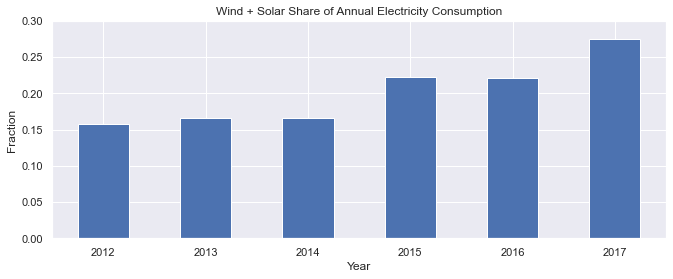

In [33]:
ax = opsd_annual.loc[2012:, 'Wind+Solar/Consumption'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0);

In [34]:
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


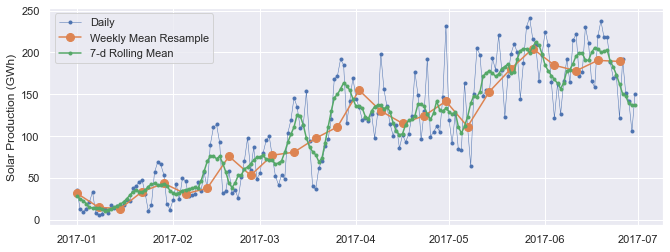

In [35]:
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'Solar'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

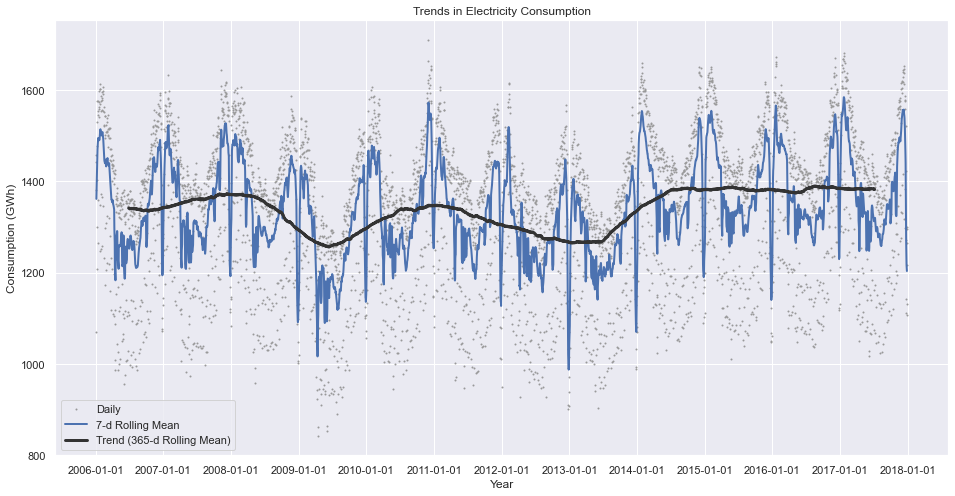

In [36]:
opsd_365d = opsd_daily[data_columns].rolling(window=365, center=True, min_periods=360).mean()

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(opsd_daily['Consumption'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(opsd_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')
ax.plot(opsd_365d['Consumption'], color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

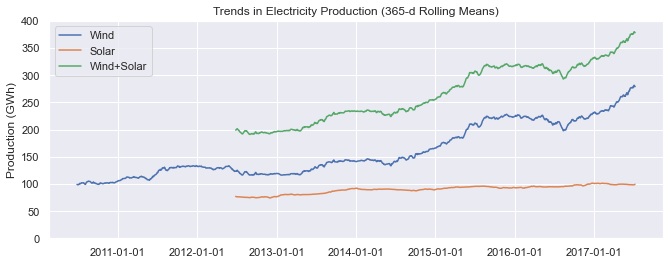

In [37]:
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(opsd_365d[nm], label=nm)
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_ylim(0, 400)
    ax.legend()
    ax.set_ylabel('Production (GWh)')
    ax.set_title('Trends in Electricity Production (365-d Rolling Means)');